In [1]:
"""
The script demonstrates a simple example of using ART with Keras. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# replace tqdm imported by any other module with tqdm.notebook
import sys
import tqdm
from tqdm.notebook import tqdm
sys.modules["tqdm"].tqdm = tqdm
sys.modules["tqdm.tqdm"] = tqdm
import ipywidgets as widgets # check if this is installed to make normal tqdm work inside the notebook

import os
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input, VGG16

from art.estimators.classification import KerasClassifier

from art.attacks.evasion import SpatialTransformation
from art.attacks.evasion import FastGradientMethod

from art.defences.trainer import AdversarialTrainer

# from art.utils import load_mnist
from art.utils import load_dataset

#this is what makes the plots transparent in notebooks
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
# sn.set() #this changes the style of all plots, and imshow shows up wrong
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import platform
import subprocess
import shutil
import load10_temp as ltemp

Using TensorFlow backend.


In [2]:
img_size = 32

render_util_folder = os.getcwd()
blender_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\blender-2.78c-windows64" 

dataset_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\greebles-generator-master\Greebles_3DS_10"
render_folder = os.path.join(os.getcwd(), "greebles_10") #reduced dataset of 10

if os.path.exists(render_folder) and os.path.isdir(render_folder):
    shutil.rmtree(render_folder)
    
if not os.path.isdir(dataset_folder):
    raise OSError(2, 'No such directory', str(dataset_folder))
if not os.path.exists(os.path.join(render_util_folder, 'render.py')):
    raise OSError(2, 'render.py not found', str(render_util_folder))

render_script = os.path.join(render_util_folder, 'render.py')

# Find the correct version of blender depending on the OS
if (platform.system() == "Windows"):
    blender_exec = os.path.join(blender_folder, 'blender.exe')
else:
    blender_exec = os.path.join(blender_folder, 'blender')
    
if not os.path.exists(os.path.join(blender_folder, blender_exec)):
    raise OSError(2, 'Blender executable not found', str(blender_folder))

# If you want to split command automatically
# import shlex; shlex.split("/bin/prog -i data.txt -o \"more data.txt\"")
# https://janakiev.com/blog/python-shell-commands/


set_mode = 'specific_all'
set_type = 'specific_angle'
#####################################
# Generate training set
blender_process = subprocess.run([blender_exec, '-b', '-P', render_script, '--', 
                    '-st', set_type, '-sm', set_mode, '-rp', render_folder, '-dp', dataset_folder, '-rm', 'none', '-pf', 'tensorflow',
                    '-is', str(img_size), '-ni', '1', '-xr', '0', '-yr', '0', '-zr', '0'])

# Move training set to folder                    
source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
ltemp.move_to_folder(source_folder, os.path.join(source_folder, "train"))

In [3]:
# Step 1: Get training set

(x_train, y_train) = ltemp.load_dataset_temp("train", source_folder)
x_train = np.array(x_train, dtype='float64')
y_train = np.array(y_train, dtype='float32')

print(x_train.shape)
print(y_train.shape)
y_train

(10, 32, 32, 1)
(10, 10)


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [4]:
# Put all the different angles in a dictionary to access individually later
all_test = {}
# Generate test set
for z in range(-90,90+1,1):
    
    blender_process = subprocess.run([blender_exec, '-b', '-P', render_script, '--', 
                        '-st', set_type, '-sm', set_mode, '-rp', render_folder, '-dp', dataset_folder, '-rm', 'none', '-pf', 'tensorflow',
                        '-is', str(img_size), '-ni', '1', '-xr', '0', '-yr', '0', '-zr', str(z)])

    # Move training set to folder                    
    source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
    ltemp.move_to_folder(source_folder, os.path.join(source_folder, "test"))
    
    print(z)
    (x_test, y_test) = ltemp.load_dataset_temp("test", source_folder)
    x_test = np.array(x_test, dtype='float64')
    y_test = np.array(y_test, dtype='float32')
    
    all_test[str(z)] = (x_test, y_test)

-90
-89
-88
-87
-86
-85
-84
-83
-82
-81
-80
-79
-78
-77
-76
-75
-74
-73
-72
-71
-70
-69
-68
-67
-66
-65
-64
-63
-62
-61
-60
-59
-58
-57
-56
-55
-54
-53
-52
-51
-50
-49
-48
-47
-46
-45
-44
-43
-42
-41
-40
-39
-38
-37
-36
-35
-34
-33
-32
-31
-30
-29
-28
-27
-26
-25
-24
-23
-22
-21
-20
-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


In [56]:
(x_test, y_test) = all_test['90']

In [6]:
# Normalize images
x_train *= (1.0/x_train.max())
x_test *= (1.0/x_test.max())
# x_train *= (1.0/138)
# x_test *= (1.0/138)

print(np.max(x_train))
print(np.min(x_train))
print(np.max(x_test))
print(np.min(x_test))

1.0
0.3670886075949367
1.0
0.35000000000000003


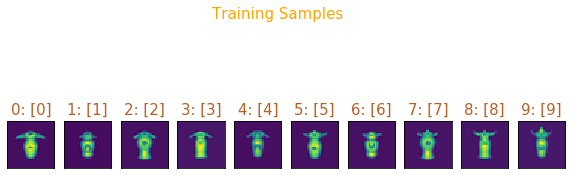

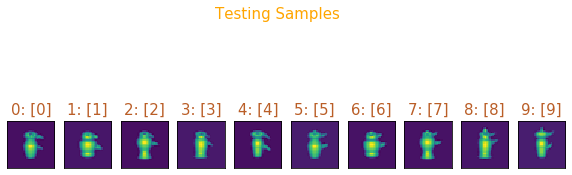

In [7]:
# Step 1.1: Visualize training set and labels
fig, axes = plt.subplots(1,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i][:,:,0], interpolation='nearest')
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(1,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i][:,:,0])
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Testing Samples', fontsize=15, color='orange')

plt.show()

In [145]:
# Step 2: Create the model
keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(32, 32, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(
    loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
)
#############################
# model.add(ResNet50(input_shape=(img_size,img_size,1),include_top=False, pooling='avg', weights=None))
# model.add(Dense(10, activation="softmax"))

# model.add(VGG16(input_shape=(img_size,img_size,1),include_top=True, pooling='max', weights=None, classes=10))

# model.compile(
#     loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"]
# )

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 4)         104       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 10)        1010      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total para

In [146]:
# Step 3: Create the ART classifier
min_pixel_value = 0.0
max_pixel_value = 1.0
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

In [147]:
# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=30)

all_acc = {}

Epoch 1/30
1/1 [==============================] - 0s 332ms/step - loss: 2.2947 - acc: 0.1562
Epoch 2/30
1/1 [==============================] - 0s 7ms/step - loss: 2.3318 - acc: 0.0625
Epoch 3/30
1/1 [==============================] - 0s 8ms/step - loss: 2.2734 - acc: 0.1406
Epoch 4/30
1/1 [==============================] - 0s 10ms/step - loss: 2.2572 - acc: 0.1406
Epoch 5/30
1/1 [==============================] - 0s 8ms/step - loss: 2.2705 - acc: 0.2344
Epoch 6/30
1/1 [==============================] - 0s 9ms/step - loss: 2.2576 - acc: 0.0938
Epoch 7/30
1/1 [==============================] - 0s 9ms/step - loss: 2.2475 - acc: 0.1875
Epoch 8/30
1/1 [==============================] - 0s 7ms/step - loss: 2.2425 - acc: 0.1875
Epoch 9/30
1/1 [==============================] - 0s 9ms/step - loss: 2.1567 - acc: 0.2812
Epoch 10/30
1/1 [==============================] - 0s 8ms/step - loss: 2.2136 - acc: 0.0625
Epoch 11/30
1/1 [==============================] - 0s 8ms/step - loss: 2.1331 - acc: 0

Accuracy on benign test examples: 40.0%
[0 1 2 3 4 5 6 7 8 9] 10
[5 6 7 8] 4
Accuracy Score : 0.4
Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.20      1.00      0.33         1
           6       0.50      1.00      0.67         1
           7       0.50      1.00      0.67         1
           8       1.00      1.00      1.00         1
           9       0.00      0.00      0.00         1

    accuracy                           0.40        10
   macro avg       0.22      0.40      0.27        10
weighted avg       0.22      0.40      0.27        10



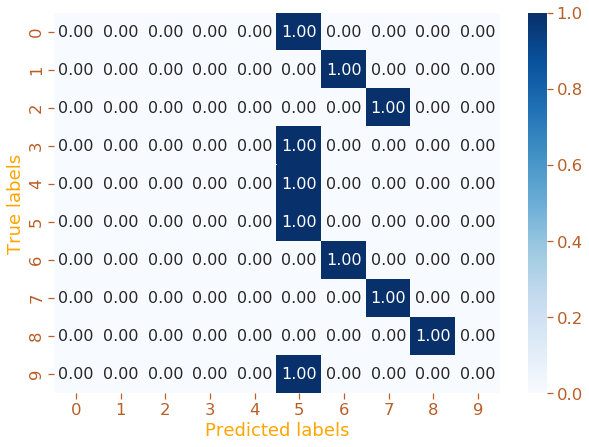

In [148]:
# Step 5: Evaluate the ART classifier on benign test examples
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
all_acc['nat'] = accuracy * 100

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize, https://stackoverflow.com/questions/20927368/python-how-to-normalize-a-confusion-matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
plt.figure(figsize=(10,7))

with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues

plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

In [149]:
all_acc = {}
for k in all_test.keys():
    (x_test, y_test) = all_test[k]
    
    # Calculate accuracy
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    all_acc[k] = accuracy
    print("Accuracy on {} degrees: {}%".format(k, accuracy * 100))

Accuracy on -90 degrees: 50.0%
Accuracy on -89 degrees: 50.0%
Accuracy on -88 degrees: 50.0%
Accuracy on -87 degrees: 50.0%
Accuracy on -86 degrees: 50.0%
Accuracy on -85 degrees: 50.0%
Accuracy on -84 degrees: 50.0%
Accuracy on -83 degrees: 50.0%
Accuracy on -82 degrees: 50.0%
Accuracy on -81 degrees: 50.0%
Accuracy on -80 degrees: 50.0%
Accuracy on -79 degrees: 50.0%
Accuracy on -78 degrees: 50.0%
Accuracy on -77 degrees: 50.0%
Accuracy on -76 degrees: 50.0%
Accuracy on -75 degrees: 50.0%
Accuracy on -74 degrees: 50.0%
Accuracy on -73 degrees: 50.0%
Accuracy on -72 degrees: 50.0%
Accuracy on -71 degrees: 50.0%
Accuracy on -70 degrees: 60.0%
Accuracy on -69 degrees: 60.0%
Accuracy on -68 degrees: 60.0%
Accuracy on -67 degrees: 60.0%
Accuracy on -66 degrees: 60.0%
Accuracy on -65 degrees: 60.0%
Accuracy on -64 degrees: 60.0%
Accuracy on -63 degrees: 60.0%
Accuracy on -62 degrees: 60.0%
Accuracy on -61 degrees: 60.0%
Accuracy on -60 degrees: 60.0%
Accuracy on -59 degrees: 50.0%
Accuracy

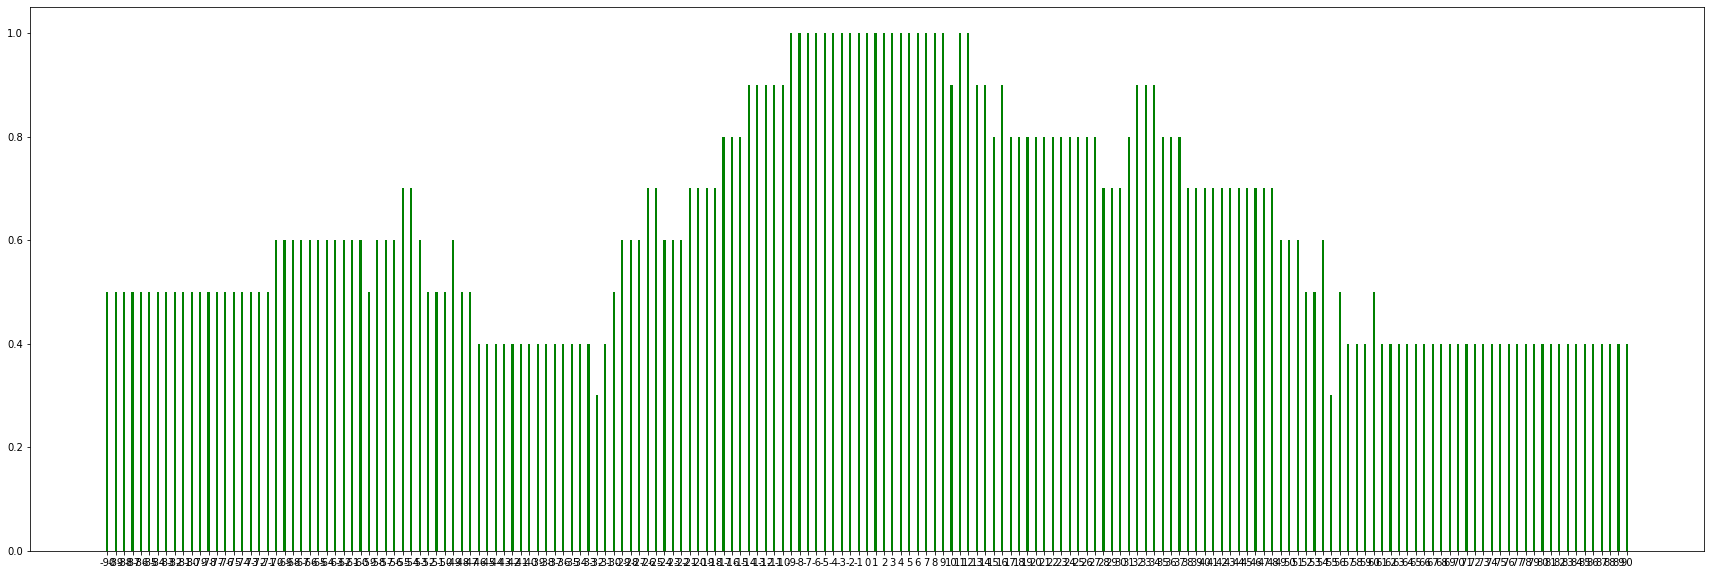

In [150]:
fig = plt.figure(figsize=(30,10))
plt.bar(all_acc.keys(), all_acc.values(), width = 0.25, color='g')
plt.show()

In [8]:
# Step 6: Generate adversarial test examples

# Craft adversarial samples
print("Create adversarial attack")
attack = SpatialTransformation(classifier=classifier, max_translation=10.0, num_translations=1, max_rotation=30.0, num_rotations=1)
# attack = FastGradientMethod(classifier, eps=0.1)
print("Craft attack on training examples")
x_train_adv = attack.generate(x_train)
print("Craft attack test examples")
x_test_adv = attack.generate(x_test)

print(x_train_adv.shape)
print(x_test_adv.shape)

Create adversarial attack
Craft attack on training examples




Craft attack test examples
(600, 28, 28, 1)
(600, 28, 28, 1)


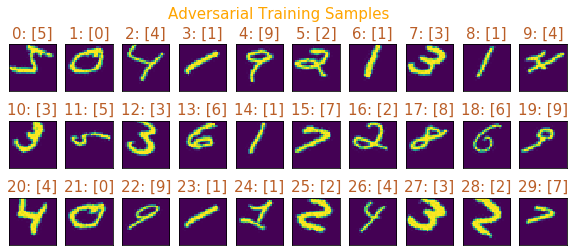

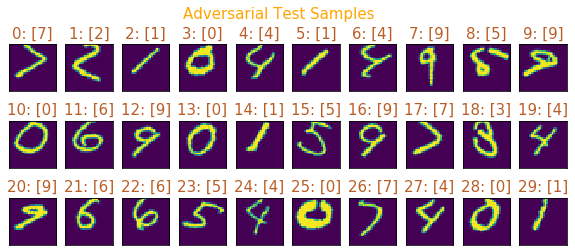

In [9]:
# Step 6.1: Visualize adversarial samples
fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train_adv[i][:,:,0])
    true_label = np.argwhere(y_train[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Adversarial Training Samples', fontsize=15, color='orange')

fig, axes = plt.subplots(3,10, figsize=(10,4))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test_adv[i][:,:,0])
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=true_label, number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Adversarial Test Samples', fontsize=15, color='orange')

plt.show()

In [10]:
# classifier.save("model.h5", path=".")

Accuracy on adversarial test examples before AT: 7.000000000000001%
[0 1 2 3 4 5 6 7 8 9] 10
[0 1 2 3 4 5 6 7 8 9] 10
Accuracy Score : 0.07
Report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.04      0.01      0.02        73
           2       0.01      0.02      0.01        64
           3       0.00      0.00      0.00        62
           4       0.10      0.30      0.15        67
           5       0.31      0.07      0.12        56
           6       0.05      0.06      0.06        52
           7       0.00      0.00      0.00        57
           8       0.10      0.12      0.10        52
           9       0.12      0.11      0.12        64

    accuracy                           0.07       600
   macro avg       0.07      0.07      0.06       600
weighted avg       0.07      0.07      0.06       600



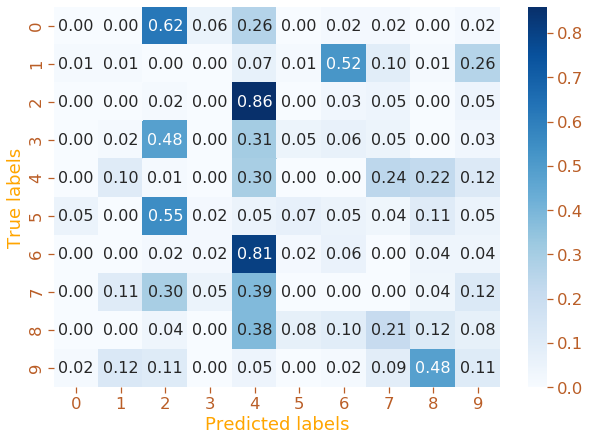

In [11]:
# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples before AT: {}%".format(accuracy * 100))
all_acc['adv_before_AT'] = accuracy * 100

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))
plt.figure(figsize=(10,7), facecolor='None')
with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

In [12]:
# Step 8: Create adversarial trainer and perform adversarial training
adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=1.0)
adv_trainer.fit(x_train_adv, y_train, batch_size=64, nb_epochs=3)

Adversarial training epochs: 100%|██████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


Accuracy on adversarial test examples after AT: 11.5%
{'nat': 82.16666666666667, 'adv_before_AT': 7.000000000000001, 'adv_after_AT': 11.5}
[0 1 2 3 4 5 6 7 8 9] 10
[0 1 2 3 4 5 6 7 9] 9
Accuracy Score : 0.115
Report : 
              precision    recall  f1-score   support

           0       0.18      0.70      0.28        53
           1       0.75      0.08      0.15        73
           2       0.01      0.02      0.01        64
           3       0.00      0.00      0.00        62
           4       0.02      0.01      0.02        67
           5       0.13      0.04      0.06        56
           6       0.81      0.33      0.47        52
           7       0.05      0.07      0.06        57
           8       0.00      0.00      0.00        52
           9       0.02      0.02      0.02        64

    accuracy                           0.12       600
   macro avg       0.20      0.13      0.11       600
weighted avg       0.20      0.12      0.10       600



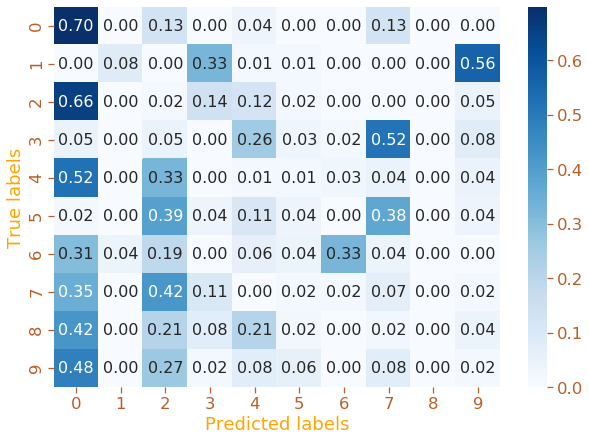

In [13]:
# Step 9: Evaluate new robustly trained classifier
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples after AT: {}%".format(accuracy * 100))
all_acc['adv_after_AT'] = accuracy * 100

print(all_acc)

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

fmt = '.2g'
# Normalize
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]; fmt = '.2f'

print(np.unique(y_true), len(np.unique(y_true)))
print(np.unique(y_pred), len(np.unique(y_pred)))

print('Accuracy Score :', accuracy_score(y_true, y_pred))
print('Report : ')
print(classification_report(y_true, y_pred))

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[0]))

plt.figure(figsize=(10,7), facecolor='None')

with sn.plotting_context(context="notebook", font_scale=1.5), \
plt.rc_context({'axes.labelcolor':'orange', 'xtick.color':'#ba5e27', 'ytick.color':'#ba5e27'}):
    hm = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=fmt, annot_kws={"size": 16}) #cmap: inferno; Blues
plt.xlabel('Predicted labels');
plt.ylabel('True labels');

plt.show()

In [14]:
dir(classifier)
# predictions[1]
# np.argmax(predictions, axis=1)
# classifier._loss
# classifier._loss_gradients
classifier.loss_gradient

d:\users\enzo\desktop\poke102938\school\rit no sync\research\gan\greebles-generator-master\adversarial-robustness-toolbox\art\estimators\classification\keras.py:714: DeprecationWarning: Function 'channel_index' is deprecated and will be removed in future release 1.5.0. It will be replaced by 'channels_first'.
  self.channel_index,


<bound method InputFilter.__init__.<locals>.make_replacement.<locals>.replacement_function of art.estimators.classification.keras.KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x0000026995291948>, use_logits=False, channel_index=<art.utils._Deprecated object at 0x0000026991B98D08>, channels_first=False, clip_values=array([0., 1.], dtype=float32), preprocessing_defences=None, postprocessing_defences=None, preprocessing=(0, 1), input_layer=0, output_layer=0)>